## Spotting Fake Reviews

In [47]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, mean_squared_error
from time import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
import nltk
from nltk import pos_tag_sents
from nltk.tokenize import TreebankWordTokenizer
from scipy.interpolate import interp1d

In [61]:
def plot_roc_curve(y_true, y_pred, title_fontsize=22, 
                   text_fontsize=17, tick_fontsize=15, label=""):
    """
    Funzione che permette di rappresentare 
    la curva ROC 
    
    
    Parametri
    ---------
    
    y_true: Formato list
            contiene i valori osservati della y
               
    y_pred: formato list
             contiene i valori predetti della y

    """ 
    plt.figure(figsize=(20,6))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=label)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
             label='Random classification')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False positive rate", fontsize=text_fontsize)
    plt.ylabel("True positive rate", fontsize=text_fontsize)
    plt.tick_params(labelsize=tick_fontsize)
    plt.legend(loc='lower right', fontsize=text_fontsize, shadow=True)
    plt.title("ROC Curve, area = {:.3f}".format(area), 
              fontsize=title_fontsize)

## Import Dataset

The dataset contains 1600 reviews that can be differentiate in 4 subsets:
1. Truthful – positive polarity
2. Fake – positive polarity
3. Truthful – negative polarity
4. Fake – negative polarity  

In [3]:
data = pd.read_json('./op_spam_v1.4.json')

In [34]:
data.head()

,file,description,text,truth,polarity,lowercase,removing punctuation,removal stopwords,stemming,lemmatization,tokenization,POS
0,/negative_polarity/deceptive_from_MTurk/fold1/...,hilton_1,We stayed at the Schicago Hilton for 4 days an...,False,False,we stayed at the schicago hilton for 4 days an...,we stayed at the schicago hilton for 4 days an...,stayed schicago hilton 4 days 3 nights confere...,stay schicago hilton 4 day 3 night confer say ...,stay schicago hilton 4 day 3 night confer say ...,"[We, stayed, at, the, Schicago, Hilton, for, 4...","[(We, PRP), (stayed, VBD), (at, IN), (the, DT)..."
1,/negative_polarity/deceptive_from_MTurk/fold1/...,hilton_10,Hotel is located 1/2 mile from the train stati...,False,False,hotel is located 1/2 mile from the train stati...,hotel is located 12 mile from the train statio...,hotel located 12 mile train station quite hike...,hotel locat 12 mile train station quit hike yo...,hotel locat 12 mile train station quit hike yo...,"[Hotel, is, located, 1/2, mile, from, the, tra...","[(Hotel, NN), (is, VBZ), (located, VBN), (1/2,..."
2,/negative_polarity/deceptive_from_MTurk/fold1/...,hilton_11,I made my reservation at the Hilton Chicago be...,False,False,i made my reservation at the hilton chicago be...,i made my reservation at the hilton chicago be...,made reservation hilton chicago believing goin...,made reserv hilton chicago believ go stay clas...,made reserv hilton chicago believ go stay clas...,"[I, made, my, reservation, at, the, Hilton, Ch...","[(I, PRP), (made, VBD), (my, PRP$), (reservati..."
3,/negative_polarity/deceptive_from_MTurk/fold1/...,hilton_12,"When most people think Hilton, they think luxu...",False,False,"when most people think hilton, they think luxu...",when most people think hilton they think luxur...,people think hilton think luxury know wish id ...,peopl think hilton think luxuri know wish id h...,peopl think hilton think luxuri know wish id h...,"[When, most, people, think, Hilton, ,, they, t...","[(When, WRB), (most, JJS), (people, NNS), (thi..."
4,/negative_polarity/deceptive_from_MTurk/fold1/...,hilton_13,My husband and I recently stayed stayed at the...,False,False,my husband and i recently stayed stayed at the...,my husband and i recently stayed stayed at the...,husband recently stayed stayed hilton chicago ...,husband recent stay stay hilton chicago horrib...,husband recent stay stay hilton chicago horrib...,"[My, husband, and, I, recently, stayed, stayed...","[(My, PRP$), (husband, NN), (and, CC), (I, PRP..."


In [38]:
y = data['truth'].tolist()
for x in y:
    if x == True:
        x = 1
    if x == False:
        x = 0

## Data processing

Lowercase: A --> a

In [4]:
data['lowercase'] = data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#data['text'] = data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
print(data['lowercase'].head())

0    we stayed at the schicago hilton for 4 days an...
1    hotel is located 1/2 mile from the train stati...
2    i made my reservation at the hilton chicago be...
3    when most people think hilton, they think luxu...
4    my husband and i recently stayed stayed at the...
Name: lowercase, dtype: object


Removing punctuation

In [6]:
data['removing punctuation'] = data['lowercase'].str.replace('[^\w\s]','')
#data['text'] = data['text'].str.replace('[^\w\s]','')
print(data['removing punctuation'].head())

0    we stayed at the schicago hilton for 4 days an...
1    hotel is located 12 mile from the train statio...
2    i made my reservation at the hilton chicago be...
3    when most people think hilton they think luxur...
4    my husband and i recently stayed stayed at the...
Name: removing punctuation, dtype: object


Removal stopwords: words which not contain enough significance like (in, which, with, a...)

In [11]:
stop = stopwords.words('english')
data['removal stopwords'] = data['removing punctuation'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
print(data['removal stopwords'].head())

0    stayed schicago hilton 4 days 3 nights confere...
1    hotel located 12 mile train station quite hike...
2    made reservation hilton chicago believing goin...
3    people think hilton think luxury know wish id ...
4    husband recently stayed stayed hilton chicago ...
Name: removal stopwords, dtype: object


Stemming: cutting the prefixes or the suffixes

In [14]:
st = PorterStemmer()
data['stemming'] = data['removal stopwords'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
#data['text'] = data['text'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
print(data['stemming'].head())

0    stay schicago hilton 4 day 3 night confer say ...
1    hotel locat 12 mile train station quit hike yo...
2    made reserv hilton chicago believ go stay clas...
3    peopl think hilton think luxuri know wish id h...
4    husband recent stay stay hilton chicago horrib...
Name: stemming, dtype: object


Lemmanization: morphological analysis of the words that are replaced by the lemma found in a dictionary (studying = study)

In [17]:
data['lemmatization'] = data['stemming'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#data['text'] = data['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
print(data['lemmatization'].head())

0    stay schicago hilton 4 day 3 night confer say ...
1    hotel locat 12 mile train station quit hike yo...
2    made reserv hilton chicago believ go stay clas...
3    peopl think hilton think luxuri know wish id h...
4    husband recent stay stay hilton chicago horrib...
Name: lemmatization, dtype: object


Tokenization: process of segmenting running text into words and sentences

In [20]:
data['tokenization'] = data.apply(lambda x: nltk.word_tokenize(x['text']), axis=1)
#data['text'] = data.apply(lambda x: nltk.word_tokenize(x['text']), axis=1)
print(data['tokenization'].head())

0    [We, stayed, at, the, Schicago, Hilton, for, 4...
1    [Hotel, is, located, 1/2, mile, from, the, tra...
2    [I, made, my, reservation, at, the, Hilton, Ch...
3    [When, most, people, think, Hilton, ,, they, t...
4    [My, husband, and, I, recently, stayed, stayed...
Name: tokenization, dtype: object


Tagged Tokens: assign part of the speech to each word such noum, pronoum, adjective…

In [25]:
data['POS'] = pos_tag_sents(data['tokenization'])
print(data['POS'].head())

0    [(We, PRP), (stayed, VBD), (at, IN), (the, DT)...
1    [(Hotel, NN), (is, VBZ), (located, VBN), (1/2,...
2    [(I, PRP), (made, VBD), (my, PRP$), (reservati...
3    [(When, WRB), (most, JJS), (people, NNS), (thi...
4    [(My, PRP$), (husband, NN), (and, CC), (I, PRP...
Name: POS, dtype: object


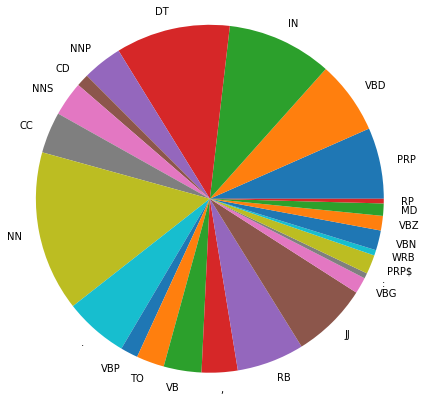

In [27]:
count = {}
for tuples in data['POS']:
    for tuplea in tuples:
        count[tuplea[1]] = count.get(tuplea[1], 0) + 1
        

inds = np.where(np.array(list(count.values())) > 1000)[0]

tags = np.array(list(count.keys()))[inds]
freqs = np.array(list(count.values()))[inds]

plt.pie(freqs, labels = tags, radius=2)
plt.show()

Legend: NN: Noun, singular or mass; MD Modal; VB: Verb, base form; IN: Preposition or subordinating conjunction; JJ: Adjective; VBP: Verb, non-3rd person singular present; NNS: Noun, plural; CD: Cardinal number; VBD: Verb, past tense; RB: Adverb.

#### Count Vectorizer

In [30]:
count_v = CountVectorizer(max_features=1000, lowercase=True, analyzer ='word')
tokenizer = TreebankWordTokenizer()

#tokenize
count_v.set_params(tokenizer=tokenizer.tokenize)
# remove English stop words
count_v.set_params(stop_words='english')
# include 1-grams and 2-grams
count_v.set_params(ngram_range=(1, 2))
# ignore terms that appear in more than 50% of the documents
count_v.set_params(max_df=0.5)
# only keep terms that appear in at least 2 documents
count_v.set_params(min_df=2)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.5, max_features=1000, min_df=2,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<bound method TreebankWordTokenizer.tokenize of <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x1a2acd6290>>,
                vocabulary=None)

#### TF-IDF

In [31]:
tf_idf = vect = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word')
tokenizer = TreebankWordTokenizer()

#tokenize
tf_idf.set_params(tokenizer=tokenizer.tokenize)
# remove English stop words
tf_idf.set_params(stop_words='english')
# include 1-grams and 2-grams
tf_idf.set_params(ngram_range=(1, 2))
# ignore terms that appear in more than 50% of the documents
tf_idf.set_params(max_df=0.5)
# only keep terms that appear in at least 2 documents
tf_idf.set_params(min_df=2) 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=1000,
                min_df=2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<bound method TreebankWordTokenizer.tokenize of <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x1a1d8e2e90>>,
                use_idf=True, vocabulary=None)

## Recall of Datasets for Count Vectorizer

In [39]:
X_count_v = count_v.fit_transform(data['lemmatization'])
#y = fl.pickle_load('*/y.pkl')

In [40]:
print(count_v.fit_transform(data['lemmatization']).todense())

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 2 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Recall of Datasets for TF-IDF

In [41]:
X_tf_idf = tf_idf.fit_transform(data['lemmatization'])
#y = fl.pickle_load('*/y.pkl')

In [42]:
print(tf_idf.fit_transform(data['lemmatization']).todense())

[[0.         0.         0.         ... 0.         0.08932029 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.26548595 ... 0.         0.37756665 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## Division of the sets

In [43]:
X_train_count_v, X_test_count_v, y_train_count_v, y_test_count_v = train_test_split(X_count_v, y, 
                                                                                    random_state=0, test_size=0.4)

X_train_tf_idf, X_test_tf_idf, y_train_tf_idf, y_test_tf_idf = train_test_split(X_tf_idf, y, 
                                                                                random_state=0, test_size=0.4)


In [44]:
X_train_sub_count_v, X_validation_sub_count_v, y_train_sub_count_v, y_validation_sub_count_v = train_test_split(X_test_count_v, y_test_count_v, random_state=0, test_size=0.5)

X_train_sub_tf_idf, X_validation_sub_tf_idf, y_train_sub_tf_idf, y_validation_sub_tf_idf = train_test_split(X_test_tf_idf, y_test_tf_idf, random_state=0, test_size=0.5)


## GRID_SEARCH n_estimator and learning_rate (Count Vectorized transformation in GradientBoostingClassifier model)

In [45]:
training_list_count_v = []
test_list_count_v = []
validation_list_count_v = []
learning_rates = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, 
                                    max_features=4, max_depth=2, random_state=0)
    gb.fit(X_train_count_v, y_train_count_v)
    #print("Learning rate: ", learning_rate)
    #print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_count_v, y_train_count_v)))
    training_list_count_v.append(gb.score(X_train_count_v, y_train_count_v))
    #print("Accuracy score (test): {0:.3f}".format(gb.score(X_test_count_v, y_test_count_v)))
    test_list_count_v.append(gb.score(X_test_count_v, y_test_count_v))
    #print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub_count_v, y_validation_sub_count_v)))
    validation_list_count_v.append(gb.score(X_validation_sub_count_v, y_validation_sub_count_v))
    #print()

## Plotting

Accuracy of training set over learning rate increment


Text(0.5, 1.0, 'Training set')

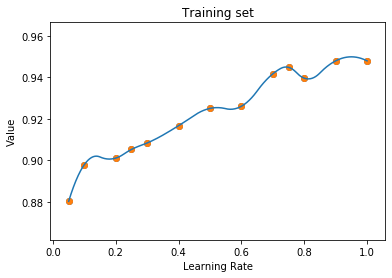

In [48]:
print('Accuracy of training set over learning rate increment')
fig_training = plt.figure()
fig_training = plt.scatter(learning_rates, training_list_count_v)
x_new = np.linspace(min(learning_rates), max(learning_rates),500)
f = interp1d(learning_rates, training_list_count_v, kind='quadratic')
y_smooth=f(x_new)
plt.plot (x_new, y_smooth)
plt.scatter (learning_rates, training_list_count_v)
plt.xlabel('Learning Rate')
plt.ylabel('Value')
plt.title('Training set')

Accuracy of test set over learning rate increment


Text(0.5, 1.0, 'Test set')

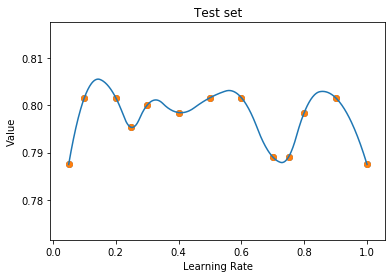

In [49]:
print('Accuracy of test set over learning rate increment')
fig_test = plt.figure()
fig_test = plt.scatter(learning_rates, test_list_count_v)
x_new = np.linspace(min(learning_rates), max(learning_rates),500)
f = interp1d(learning_rates, test_list_count_v, kind='quadratic')
y_smooth=f(x_new)
plt.plot (x_new, y_smooth)
plt.scatter (learning_rates, test_list_count_v)
plt.xlabel('Learning Rate')
plt.ylabel('Value')
plt.title('Test set')

Accuracy of validation set over learning rate increment


Text(0.5, 1.0, 'Validation set')

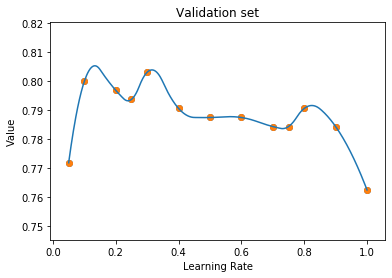

In [50]:
print('Accuracy of validation set over learning rate increment')
fig_validation = plt.figure()
fig_validation = plt.scatter(learning_rates, validation_list_count_v)
x_new = np.linspace(min(learning_rates), max(learning_rates),500)
f = interp1d(learning_rates, validation_list_count_v, kind='quadratic')
y_smooth=f(x_new)
plt.plot (x_new, y_smooth)
plt.scatter (learning_rates, validation_list_count_v)
plt.xlabel('Learning Rate')
plt.ylabel('Value')
plt.title('Validation set')

## GRID_SEARCH n_estimator and learning_rate (TF-IDF transformation in GBC model)

In [51]:
training_list_tf_idf = []
test_list_tf_idf = []
validation_list_tf_idf = []
learning_rates = [0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, 
                                    max_features=4, max_depth=2, random_state=0)
    gb.fit(X_train_tf_idf, y_train_tf_idf)
    #print("Learning rate: ", learning_rate)
    #print("Accuracy score (training): {0:.3f}".format(gb.score(X_train_tf_idf, y_train_tf_idf)))
    training_list_tf_idf.append(gb.score(X_train_tf_idf, y_train_tf_idf))
    #print("Accuracy score (test): {0:.3f}".format(gb.score(X_test_tf_idf, y_test_tf_idf)))
    test_list_tf_idf.append(gb.score(X_test_tf_idf, y_test_tf_idf))
    #print("Accuracy score (validation): {0:.3f}".format(gb.score(X_validation_sub_tf_idf, y_validation_sub_tf_idf)))
    validation_list_tf_idf.append(gb.score(X_validation_sub_tf_idf, y_validation_sub_tf_idf))
    #print()

## Plotting

Accuracy of training set over learning rate increment


Text(0.5, 1.0, 'Training set')

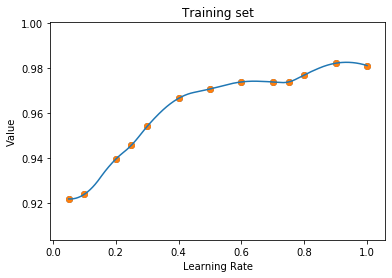

In [52]:
print('Accuracy of training set over learning rate increment')
fig_training = plt.figure()
fig_training = plt.scatter(learning_rates, training_list_tf_idf)
x_new = np.linspace(min(learning_rates), max(learning_rates),500)
f = interp1d(learning_rates, training_list_tf_idf, kind='quadratic')
y_smooth=f(x_new)
plt.plot (x_new, y_smooth)
plt.scatter (learning_rates, training_list_tf_idf)
plt.xlabel('Learning Rate')
plt.ylabel('Value')
plt.title('Training set')

Accuracy of test set over learning rate increment


Text(0.5, 1.0, 'Test set')

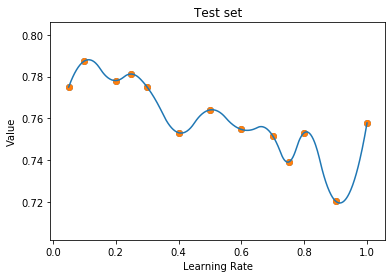

In [53]:
print('Accuracy of test set over learning rate increment')
fig_test = plt.figure()
fig_test = plt.scatter(learning_rates, test_list_tf_idf)
x_new = np.linspace(min(learning_rates), max(learning_rates),500)
f = interp1d(learning_rates, test_list_tf_idf, kind='quadratic')
y_smooth=f(x_new)
plt.plot (x_new, y_smooth)
plt.scatter (learning_rates, test_list_tf_idf)
plt.xlabel('Learning Rate')
plt.ylabel('Value')
plt.title('Test set')

Accuracy of validation set over learning rate increment


Text(0.5, 1.0, 'Validation set')

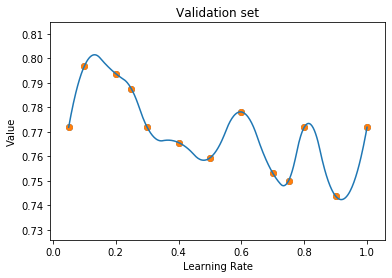

In [54]:
print('Accuracy of validation set over learning rate increment')
fig_validation = plt.figure()
fig_validation = plt.scatter(learning_rates, validation_list_tf_idf)
x_new = np.linspace(min(learning_rates), max(learning_rates),500)
f = interp1d(learning_rates, validation_list_tf_idf, kind='quadratic')
y_smooth=f(x_new)
plt.plot (x_new, y_smooth)
plt.scatter (learning_rates, validation_list_tf_idf)
plt.xlabel('Learning Rate')
plt.ylabel('Value')
plt.title('Validation set')

## Grid Search for GBC with Count Vectorized

In [55]:
'''
grid = {'learning_rate':[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'n_estimators':[100, 500, 1000, 1500],
        'max_depth':[2, 3, 4, 5],
        'max_features':['sqrt', 'log2', 'auto', 2, 4, 5, 8]
       }
t0 = time()
gs = GridSearchCV(estimator = GradientBoostingClassifier(random_state=0),
                      param_grid = grid, scoring='accuracy', n_jobs=4, iid=False, cv=10)

gs.fit(X_train_count_v, y_train_count_v)
research_time = time() - t0
print(research_time)
model_count_v = gs.best_estimator_
'''
###################################################################
#cv=4
#776.1262147426605
#GradientBoostingClassifier(criterion='friedman_mse', init=None,
#              learning_rate=0.05, loss='deviance', max_depth=3,
#              max_features=2, max_leaf_nodes=None,
#              min_impurity_decrease=0.0, min_impurity_split=None,
#              min_samples_leaf=1, min_samples_split=2,
#              min_weight_fraction_leaf=0.0, n_estimators=1500,
#              n_iter_no_change=None, presort='auto', random_state=42,
#             subsample=1.0, tol=0.0001, validation_fraction=0.1,
#              verbose=0, warm_start=False)
#Accuracy score (training): 0.991
#Accuracy score (test): 0.859
#Accuracy score (validation): 0.850
###################################################################
#cv=10
#2316.2197308540344
#GradientBoostingClassifier(criterion='friedman_mse', init=None,
#              learning_rate=0.05, loss='deviance', max_depth=5,
#              max_features=4, max_leaf_nodes=None,
#              min_impurity_decrease=0.0, min_impurity_split=None,
#              min_samples_leaf=1, min_samples_split=2,
#              min_weight_fraction_leaf=0.0, n_estimators=500,
#              n_iter_no_change=None, presort='auto', random_state=0,
#              subsample=1.0, tol=0.0001, validation_fraction=0.1,
#              verbose=0, warm_start=False)
#Accuracy score (training): 0.994
#Accuracy score (test): 0.869
#Accuracy score (validation): 0.866
###################################################################

gs_best_estimator = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

model_count_v = gs_best_estimator
print(model_count_v)
model_count_v.fit(X_train_count_v, y_train_count_v)
print("Accuracy score (training): {0:.3f}".format(model_count_v.score(X_train_count_v, 
                                                                      y_train_count_v)))
print("Accuracy score (test): {0:.3f}".format(model_count_v.score(X_test_count_v, 
                                                                  y_test_count_v)))
print("Accuracy score (validation): {0:.3f}".format(model_count_v.score(X_validation_sub_count_v, 
                                                                        y_validation_sub_count_v)))

list_count_v_score = []
list_count_v_score.append(model_count_v.score(X_train_count_v, y_train_count_v))
list_count_v_score.append(model_count_v.score(X_test_count_v, y_test_count_v))
list_count_v_score.append(model_count_v.score(X_validation_sub_count_v, y_validation_sub_count_v))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=5,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


/Users/pieroromare/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


Accuracy score (training): 0.994
Accuracy score (test): 0.869
Accuracy score (validation): 0.866


## Grid Search for GBC with TF-IDF

In [56]:
'''
grid = {'learning_rate':[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'n_estimators':[100, 500, 1000, 1500],
        'max_depth':[2, 3, 4, 5],
        'max_features':['sqrt', 'log2', 'auto', 2, 4, 5, 8]
       }
t0 = time()
gs = GridSearchCV(estimator = GradientBoostingClassifier(random_state=0),
                      param_grid = grid, scoring='accuracy', n_jobs=4, iid=False, cv=10)

gs.fit(X_train_tf_idf, y_train_tf_idf)
research_time = time() - t0
print(research_time)
model_tf_idf = gs.best_estimator_
'''
###################################################################
#cv=4
#985.9960541725159
#GradientBoostingClassifier(criterion='friedman_mse', init=None,
#              learning_rate=0.05, loss='deviance', max_depth=3,
#              max_features=5, max_leaf_nodes=None,
#              min_impurity_decrease=0.0, min_impurity_split=None,
#              min_samples_leaf=1, min_samples_split=2,
#              min_weight_fraction_leaf=0.0, n_estimators=500,
#              n_iter_no_change=None, presort='auto', random_state=42,
#              subsample=1.0, tol=0.0001, validation_fraction=0.1,
#              verbose=0, warm_start=False)
#Accuracy score (training): 0.997
#Accuracy score (test): 0.847
#Accuracy score (validation): 0.853
###################################################################
#cv=10
#3022.400599002838
#GradientBoostingClassifier(criterion='friedman_mse', init=None,
#              learning_rate=0.05, loss='deviance', max_depth=5,
#              max_features=4, max_leaf_nodes=None,
#              min_impurity_decrease=0.0, min_impurity_split=None,
#              min_samples_leaf=1, min_samples_split=2,
#              min_weight_fraction_leaf=0.0, n_estimators=500,
#              n_iter_no_change=None, presort='auto', random_state=0,
#              subsample=1.0, tol=0.0001, validation_fraction=0.1,
#              verbose=0, warm_start=False)
#Accuracy score (training): 1.000
#Accuracy score (test): 0.844
#Accuracy score (validation): 0.850
###################################################################


gs_best_estimator = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

model_tf_idf = gs_best_estimator
print(model_tf_idf)
model_tf_idf.fit(X_train_tf_idf, y_train_tf_idf)
print("Accuracy score (training): {0:.3f}".format(model_tf_idf.score(X_train_tf_idf, 
                                                                     y_train_tf_idf)))
print("Accuracy score (test): {0:.3f}".format(model_tf_idf.score(X_test_tf_idf, 
                                                                 y_test_tf_idf)))
print("Accuracy score (validation): {0:.3f}".format(model_tf_idf.score(X_validation_sub_tf_idf, 
                                                                       y_validation_sub_tf_idf)))

list_tf_idf_score = []
list_tf_idf_score.append(model_tf_idf.score(X_train_tf_idf, y_train_tf_idf))
list_tf_idf_score.append(model_tf_idf.score(X_test_tf_idf, y_test_tf_idf))
list_tf_idf_score.append(model_tf_idf.score(X_validation_sub_tf_idf, y_validation_sub_tf_idf))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=5,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


/Users/pieroromare/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


Accuracy score (training): 1.000
Accuracy score (test): 0.844
Accuracy score (validation): 0.850


## Difference in the accuracy of GBC with different text transformation

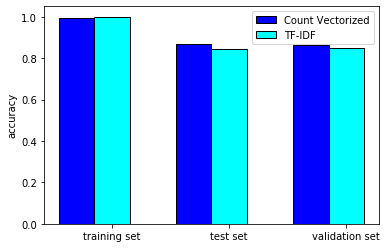

Count Vectorized: training set 0.99375 , test set 0.86875 , validation set 0.865625
TF-IDF: training set 1.0 , test set 0.84375 , validation set 0.85


In [57]:
barWidth = 0.3
bars1 = [value for value in list_count_v_score]
bars2 = [value for value in list_tf_idf_score]
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=10, label='Count Vectorized')
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', capsize=10, label='TF-IDF')
plt.xticks([r + barWidth for r in range(len(bars1))], ['training set', 'test set', 'validation set'])
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('Count Vectorized: training set', bars1[0], ', test set', bars1[1], ', validation set', bars1[2])
print('TF-IDF: training set', bars2[0], ', test set', bars2[1], ', validation set', bars2[2])

## Error

In [65]:
#mse_count_v = mean_squared_error(y_test_count_v, model_count_v.predict(X_test_count_v))
#print("MSE Count Vectorized: %.4f" % mse_count_v)
#print()
#mse_tf_idf = mean_squared_error(y_test_tf_idf, model_tf_idf.predict(X_test_tf_idf))
#print("MSE TF-IDF: %.4f" % mse_tf_idf)

## Confusion matrix

In [59]:
predictions_count_v = model_count_v.predict(X_test_count_v)
print("Confusion Matrix Count Vectorized:")
print(confusion_matrix(y_test_count_v, predictions_count_v))
print()
print("Classification Report Count Vectorized")
print(classification_report(y_test_count_v, predictions_count_v))
print()
predictions_tf_idf = model_tf_idf.predict(X_test_tf_idf)
print("Confusion Matrix TF-IDF:")
print(confusion_matrix(y_test_tf_idf, predictions_tf_idf))
print()
print("Classification Report TF-IDF")
print(classification_report(y_test_tf_idf, predictions_tf_idf))

Confusion Matrix Count Vectorized:
[[272  36]
 [ 48 284]]

Classification Report Count Vectorized
              precision    recall  f1-score   support

       False       0.85      0.88      0.87       308
        True       0.89      0.86      0.87       332

    accuracy                           0.87       640
   macro avg       0.87      0.87      0.87       640
weighted avg       0.87      0.87      0.87       640


Confusion Matrix TF-IDF:
[[270  38]
 [ 62 270]]

Classification Report TF-IDF
              precision    recall  f1-score   support

       False       0.81      0.88      0.84       308
        True       0.88      0.81      0.84       332

    accuracy                           0.84       640
   macro avg       0.84      0.84      0.84       640
weighted avg       0.85      0.84      0.84       640



## ROC Curve

Area under ROC curve Count Vectorized = 0.95

Area under ROC curve TF-IDF = 0.93


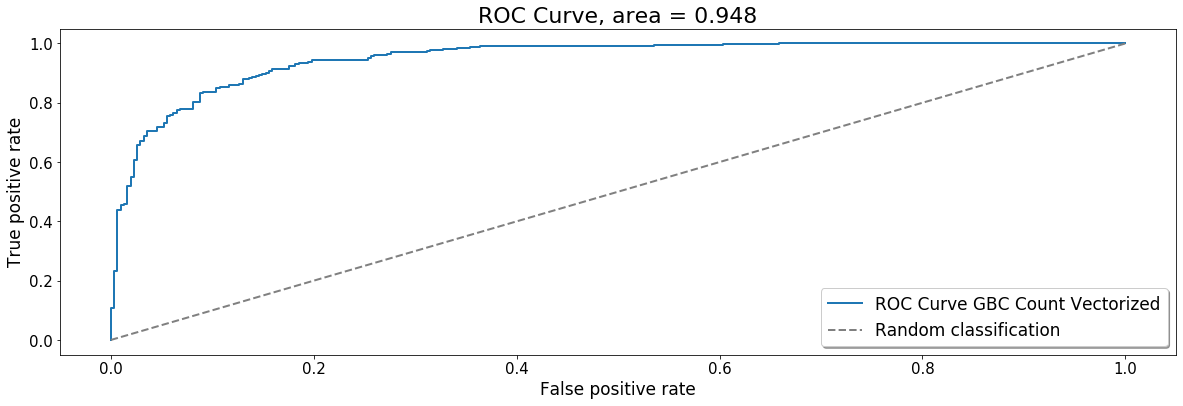

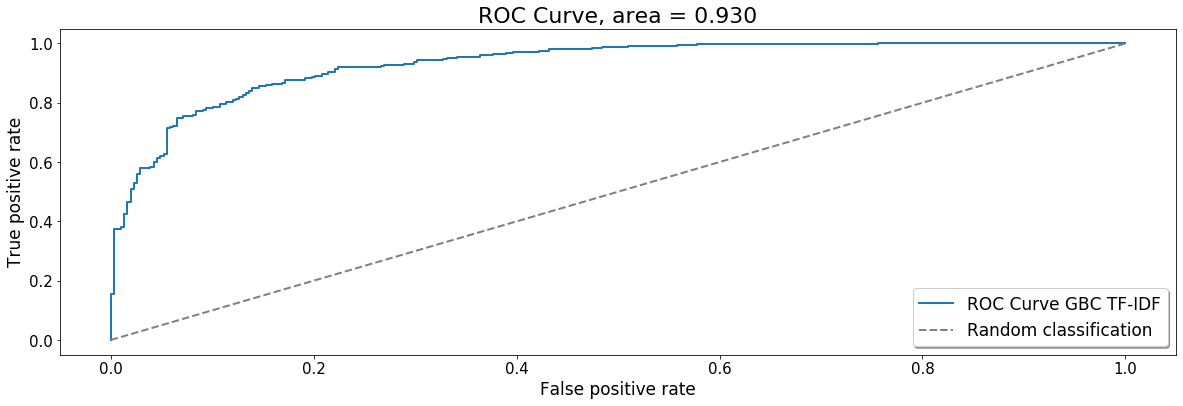

In [62]:
y_scores_model_count_v = model_count_v.predict_proba(X_test_count_v) [:, 1]
fpr_model_count_v, tpr_model_count_v, _ = roc_curve(y_test_count_v, y_scores_model_count_v)
roc_auc_model_count_v = auc(fpr_model_count_v, tpr_model_count_v)
print("Area under ROC curve Count Vectorized = {:0.2f}".format(roc_auc_model_count_v))
plot_roc_curve(y_test_count_v, y_scores_model_count_v, label='ROC Curve GBC Count Vectorized')

print()

y_scores_model_tf_idf = model_tf_idf.predict_proba(X_test_tf_idf) [:, 1]
fpr_model_tf_idf, tpr_model_tf_idf, _ = roc_curve(y_test_tf_idf, y_scores_model_tf_idf)
roc_auc_model_tf_idf = auc(fpr_model_tf_idf, tpr_model_tf_idf)
print("Area under ROC curve TF-IDF = {:0.2f}".format(roc_auc_model_tf_idf))
plot_roc_curve(y_test_tf_idf, y_scores_model_tf_idf, label='ROC Curve GBC TF-IDF')